# Guided LDA
https://www.kaggle.com/code/nvpsani/topic-modelling-using-guided-lda

In [1]:
import numpy as np
import s3fs
import boto3
import pandas as pd
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')

import re
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report

import guidedlda

[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ec2-user/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
#import data
model_data = pd.read_csv('s3://book-data-ucb-capstone-s2022/LDA_train.csv')
print('Tokenized Text DF Size:', len(model_data))

Tokenized Text DF Size: 28652


/tmp/ipykernel_28846/1016882758.py:2: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  model_data = pd.read_csv('s3://book-data-ucb-capstone-s2022/LDA_train.csv')


In [3]:
#sample model data
model_data = model_data.sample(frac=0.25, random_state=42)

In [4]:
model_data.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,bookId,title,series,author,rating,description,language,...,Fantasy,Erotica,History,Dystopia,Poetry,Biography,Manga,Thriller,Graphic Novels,Romance
17885,18885,18885,5956,2272813.Ninth_Grade_Slays,Ninth Grade Slays,The Chronicles of Vladimir Tod #2,"Heather Brewer (Goodreads Author), Z Brewer",4.14,High school totally bites when you’re half hum...,English,...,Fantasy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Romance
10186,11186,11186,47684,659546.Promise_Not_to_Tell,Promise Not to Tell,NaN,"Jennifer McMahon (Goodreads Author), Kathleen ...",3.64,Forty-one-year-old school nurse Kate Cypher ha...,English,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thriller,NaN,NaN
17757,18757,18757,27861,248884.Berserk_Vol_6,"Berserk, Vol. 6",ベルセルク / Berserk #6,"Kentaro Miura, Duane Johnson (Translator)",4.56,"Back in the day, Guts the Black Swordsman was ...",English,...,Fantasy,NaN,NaN,NaN,NaN,NaN,Manga,NaN,Graphic Novels,NaN
15936,16936,16936,49756,14740588-notorious-nineteen,Notorious Nineteen,Stephanie Plum #19,Janet Evanovich (Goodreads Author),3.94,New Jersey bounty hunter Stephanie Plum is cer...,English,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Romance
12340,13340,13340,37392,650584.Shadowdale,Shadowdale,Forgotten Realms: Avatar #1,"Scott Ciencin, Richard Awlinson (Avatar Projec...",3.71,The gods walk the Realms.Banished from the hea...,English,...,Fantasy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#preprocessing
def preprocess_text(text):

  #lowercase text
  text_preprocessed = text.lower()
  #remove punctuation
  text_preprocessed = re.sub(r'[^a-zA-Z ]+', '', text_preprocessed)
  #tokenize for stopword removal
  text_preprocessed = word_tokenize(text_preprocessed)
  #remove stopwords
  text_preprocessed = [word for word in text_preprocessed if word not in stopwords.words('english')]
  #join to make string again
  #text_preprocessed = (" ").join(text_preprocessed)

  return text_preprocessed

In [6]:
%%time
model_data['tokens'] = model_data['description'].apply(lambda x: preprocess_text(x))

CPU times: user 1min 17s, sys: 5.73 s, total: 1min 23s
Wall time: 1min 23s


## Synsets

In [7]:
def create_synsets(event):
  
  synonym = [] 
    
  for synset in wordnet.synsets(event): 
      for i in synset.lemmas(): 
          synonym.append(i.name()) # add all the synonyms available 
    
  return synonym

In [8]:
#creating library dataframe

#creating library dataframe


life_events = ['university', 'relationships', 'break ups', 'divorce', 'wedding', 
               'death', 'family', 'friendship', 'marriage']

#create synsets for select events where decent synsets exist
relationship_list = create_synsets('go_steady') + ['relationship', 'kinship', 'romance', 'dating']
marriage_list = create_synsets('marriage')
wedding_list = create_synsets('wedding') + ['matrimony']

#replace underscore (_) with space
relationship_list = [i.replace("_", " ") for i in relationship_list]
marriage_list = [i.replace("_", " ") for i in marriage_list]
wedding_list = [i.replace("_", " ") for i in wedding_list]

#remove certain words
wedding_list.remove('tie')
wedding_list.remove('marriage')
relationship_list.remove('see')

synsets = [['college', 'university', 'campus', 'academia', 'professor', 'colleges', 'universities', 'professors'], 
           relationship_list, 
           ['breakup', 'break up', 'split up', 'broken up', 'dumped', 'breaks up', 'splits up', 'dumps', 'dump', 'breaks off', 'break off'], 
           ['divorce', 'divorced', 'divorces'], 
           wedding_list,  
           ['death', 'decease', 'deceased', 'dying'],
           ['family', 'mother', 'father', 'brother', 'sister', 'mom', 'dad'],
           ['friends', 'friend', 'friendship', 'friendships'],
           marriage_list]

# Create the pandas DataFrame with column name is provided explicitly
df_lib = pd.DataFrame(life_events, columns=['life_event'])
df_lib['synsets'] = synsets
 
# print dataframe.
df_lib

,life_event,synsets
0,university,"[college, university, campus, academia, profes..."
1,relationships,"[go steady, go out, date, relationship, kinshi..."
2,break ups,"[breakup, break up, split up, broken up, dumpe..."
3,divorce,"[divorce, divorced, divorces]"
4,wedding,"[wedding, wedding ceremony, nuptials, hymeneal..."
5,death,"[death, decease, deceased, dying]"
6,family,"[family, mother, father, brother, sister, mom,..."
7,friendship,"[friends, friend, friendship, friendships]"
8,marriage,"[marriage, matrimony, union, spousal relations..."


## Guided LDA

In [9]:
#create objects required for model training

model_data['liststring'] = [','.join(map(str, l)) for l in model_data['tokens']]
corpus=model_data['liststring'].tolist()
vocab=list(set(word_tokenize(" ".join(model_data['liststring']))))
vectorizer = CountVectorizer(ngram_range=(1,2),vocabulary=vocab)
X = vectorizer.fit_transform(corpus)
word2id=vectorizer.vocabulary_

#synsets unigrams only

#define model
model = guidedlda.GuidedLDA(n_topics=8, n_iter=2000, random_state=7, refresh=20,alpha=0.01,eta=0.01)

synsets = [['college', 'university', 'campus', 'professor', 'professors'], 
           ['date', 'relationship', 'romance', 'dating'],
           ['breakup', 'dumped'], 
           ['divorce', 'divorced'], 
           ['wedding', 'nuptials', 'wedding', 'wedding', 'marry', 'wed', 'marry', 'wed'], 
           ['death', 'deceased', 'dying'],
           ['family', 'mother', 'father', 'brother', 'sister', 'mom', 'dad'],
           ['friends', 'friend', 'friendship', 'friendships']]

seed_topics = {}
for t_id, st in enumerate(synsets):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [10]:
topic_num_name = {"Topic 0":"university",
                  "Topic 1":"relationships",
                  "Topic 2":"breakups",
                  "Topic 3":"divorce",
                  "Topic 4":"wedding",
                  "Topic 5": "death",
                  "Topic 6": "family",
                  "Topic 7": "friends"}    

In [11]:
topic_list = ['universities', 'relationships', 'break ups', 'divorce', 'wedding', 'death', 'family', 'friendship']

In [12]:
def get_doc_topics(model_glda,X,num_topics,dataframe,col_name):
    """
    A function which creates dataframe with documents, their dominant topic, along with their probabilities
    
    Parameters
    -------------
    model_glda - Guided LDA trained model
    X - Document term frequency table
    num_topics - Number of topics the model was trained for
    dataframe - Dataframe consisting of cleaned text column
    col_name - Column name in dataframe holding cleaned text
    
    Returns
    -------------
    A dataframe with document number, topic, probability of topic
    """
    df_doc_top = pd.DataFrame()
    final_list = []
    for index in range(len(dataframe[col_name])):
        word_id_dict = dict((x,y) for x,y in zip([x for x in range(num_topics)],np.round(model.transform(X[index])*100,1).tolist()[0]))
        word_score_list = []
        for index in range(num_topics):
            try:
                value = word_id_dict[index]
            except:
                value = 0
            word_score_list.append(value)
        final_list.append(word_score_list)

    df_doc_top = pd.DataFrame(final_list)
    df_doc_top.columns = ['Topic ' + str(i) for i in range(num_topics)]
    df_doc_top.index = ['Document ' + str(i) for i in range(len(dataframe[col_name]))]

    df_doc_top["Dominant_Topic"] = df_doc_top.idxmax(axis=1).tolist()
    df_doc_top["Topic_Probability"] = df_doc_top.max(axis=1).tolist()
    #document_df = df_doc_top.reset_index().rename(columns={"index":"Document"})[["Document","Dominant_Topic","Topic_Probability"]]


    #return document_df
    return df_doc_top

In [13]:
model_data_test = pd.read_csv('s3://book-data-ucb-capstone-s2022/LDA_test.csv')

In [14]:
model_data_test['tokens'] = model_data_test['description'].apply(lambda x: preprocess_text(x))

In [15]:
#create test objects
model_data_test = pd.read_csv('s3://book-data-ucb-capstone-s2022/LDA_test.csv')

#preprocess test set
model_data_test['tokens'] = model_data_test['description'].apply(lambda x: preprocess_text(x))

#create objects required for model testing

model_data_test['liststring'] = [','.join(map(str, l)) for l in model_data_test['tokens']]
corpus=model_data_test['liststring'].tolist()
vocab=list(set(word_tokenize(" ".join(model_data_test['liststring']))))
vectorizer = CountVectorizer(ngram_range=(1,1),vocabulary=vocab)
X = vectorizer.fit_transform(corpus)
word2id=vectorizer.vocabulary_

## Train Model

In [31]:
%%time

alphas = [0.01, 0.1, 1]
seed_confidences = [0.05, 0.25, 0.5]

for alpha in alphas:
    for seed_confidence in seed_confidences:
        
        print('Alpha:', str(alpha), '& Seed Confidence', str(seed_confidence))
        
        #define model
        model = guidedlda.GuidedLDA(n_topics=8, n_iter=2000, random_state=7, refresh=20,alpha=alpha,eta=0.01)
        
        #fit model
        print('fitting model')
        model.fit(X, seed_topics=seed_topics, seed_confidence=seed_confidence)
        print('model fitted')
        print('')
        
        #get topics
        print('getting topics')
        document_df_test=get_doc_topics(model,X,8,model_data_test,"liststring")
        topic_list = ['university', 'relationships', 'break ups', 'divorce', 'wedding', 'death', 'family', 'friendship', 'Dominant_Topic', 'Topic_Probability']
        document_df_test.columns = topic_list
        print('got topics')
        
        #convert preds to 
        preds = document_df_test[['university', 'relationships', 'break ups', 'divorce', 'wedding', 'death', 'family', 'friendship']]
        cols = ['university', 'relationships', 'break ups', 'divorce', 'wedding', 'death', 'family', 'friendship']

        #turn preds into True/False
        for col_name in cols:
            preds[col_name] =  preds[col_name] > 20
        
        #save both document_df_test and preds to csvs
        probs_csv_name = 'glda_probs_alpha_' + str(alpha) + '_seedconf_' + str(seed_confidence) + '.csv'
        bool_csv_name = 'glda_bool_alpha_' + str(alpha) + '_seedconf_' + str(seed_confidence) + '.csv'
        
        document_df_test.to_csv(probs_csv_name)
        preds.to_csv(bool_csv_name)



INFO:guidedlda:n_documents: 1000
INFO:guidedlda:vocab_size: 18481
INFO:guidedlda:n_words: 77613
INFO:guidedlda:n_topics: 8
INFO:guidedlda:n_iter: 2000


Alpha: 0.01 & Seed Confidence 0.05
fitting model


INFO:guidedlda:<0> log likelihood: -983505
INFO:guidedlda:<20> log likelihood: -794185
INFO:guidedlda:<40> log likelihood: -785772
INFO:guidedlda:<60> log likelihood: -781424
INFO:guidedlda:<80> log likelihood: -778261
INFO:guidedlda:<100> log likelihood: -776024
INFO:guidedlda:<120> log likelihood: -774301
INFO:guidedlda:<140> log likelihood: -772792
INFO:guidedlda:<160> log likelihood: -771504
INFO:guidedlda:<180> log likelihood: -770962
INFO:guidedlda:<200> log likelihood: -769332
INFO:guidedlda:<220> log likelihood: -768374
INFO:guidedlda:<240> log likelihood: -767725
INFO:guidedlda:<260> log likelihood: -766826
INFO:guidedlda:<280> log likelihood: -766535
INFO:guidedlda:<300> log likelihood: -765968
INFO:guidedlda:<320> log likelihood: -765612
INFO:guidedlda:<340> log likelihood: -764584
INFO:guidedlda:<360> log likelihood: -764237
INFO:guidedlda:<380> log likelihood: -763136
INFO:guidedlda:<400> log likelihood: -762097
INFO:guidedlda:<420> log likelihood: -761716
INFO:guidedlda:<

model fitted

getting topics


/tmp/ipykernel_22595/3263608388.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_doc_top["Topic_Probability"] = df_doc_top.max(axis=1).tolist()
<timed exec>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:guidedlda:n_documents: 1000
INFO:guidedlda:vocab_size: 18481
INFO:guidedlda:n_words: 77613
INFO:guidedlda:n_topics: 8
INFO:guidedlda:n_iter: 2000


got topics
Alpha: 0.01 & Seed Confidence 0.25
fitting model


INFO:guidedlda:<0> log likelihood: -983505
INFO:guidedlda:<20> log likelihood: -794121
INFO:guidedlda:<40> log likelihood: -786003
INFO:guidedlda:<60> log likelihood: -781856
INFO:guidedlda:<80> log likelihood: -777961
INFO:guidedlda:<100> log likelihood: -775343
INFO:guidedlda:<120> log likelihood: -774076
INFO:guidedlda:<140> log likelihood: -772752
INFO:guidedlda:<160> log likelihood: -771072
INFO:guidedlda:<180> log likelihood: -770040
INFO:guidedlda:<200> log likelihood: -768714
INFO:guidedlda:<220> log likelihood: -767583
INFO:guidedlda:<240> log likelihood: -767058
INFO:guidedlda:<260> log likelihood: -766731
INFO:guidedlda:<280> log likelihood: -765779
INFO:guidedlda:<300> log likelihood: -765311
INFO:guidedlda:<320> log likelihood: -764954
INFO:guidedlda:<340> log likelihood: -764092
INFO:guidedlda:<360> log likelihood: -763483
INFO:guidedlda:<380> log likelihood: -763013
INFO:guidedlda:<400> log likelihood: -762430
INFO:guidedlda:<420> log likelihood: -761906
INFO:guidedlda:<

model fitted

getting topics


/tmp/ipykernel_22595/3263608388.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_doc_top["Topic_Probability"] = df_doc_top.max(axis=1).tolist()
<timed exec>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:guidedlda:n_documents: 1000
INFO:guidedlda:vocab_size: 18481
INFO:guidedlda:n_words: 77613
INFO:guidedlda:n_topics: 8
INFO:guidedlda:n_iter: 2000


got topics
Alpha: 0.01 & Seed Confidence 0.5
fitting model


INFO:guidedlda:<0> log likelihood: -983505
INFO:guidedlda:<20> log likelihood: -793993
INFO:guidedlda:<40> log likelihood: -784974
INFO:guidedlda:<60> log likelihood: -782070
INFO:guidedlda:<80> log likelihood: -778045
INFO:guidedlda:<100> log likelihood: -776063
INFO:guidedlda:<120> log likelihood: -774367
INFO:guidedlda:<140> log likelihood: -773760
INFO:guidedlda:<160> log likelihood: -772460
INFO:guidedlda:<180> log likelihood: -771057
INFO:guidedlda:<200> log likelihood: -770303
INFO:guidedlda:<220> log likelihood: -769641
INFO:guidedlda:<240> log likelihood: -768329
INFO:guidedlda:<260> log likelihood: -768501
INFO:guidedlda:<280> log likelihood: -767214
INFO:guidedlda:<300> log likelihood: -766364
INFO:guidedlda:<320> log likelihood: -765941
INFO:guidedlda:<340> log likelihood: -765581
INFO:guidedlda:<360> log likelihood: -765138
INFO:guidedlda:<380> log likelihood: -764670
INFO:guidedlda:<400> log likelihood: -764225
INFO:guidedlda:<420> log likelihood: -763756
INFO:guidedlda:<

model fitted

getting topics


/tmp/ipykernel_22595/3263608388.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_doc_top["Topic_Probability"] = df_doc_top.max(axis=1).tolist()
<timed exec>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:guidedlda:n_documents: 1000
INFO:guidedlda:vocab_size: 18481
INFO:guidedlda:n_words: 77613
INFO:guidedlda:n_topics: 8
INFO:guidedlda:n_iter: 2000


got topics
Alpha: 0.1 & Seed Confidence 0.05
fitting model


INFO:guidedlda:<0> log likelihood: -968663
INFO:guidedlda:<20> log likelihood: -785619
INFO:guidedlda:<40> log likelihood: -777408
INFO:guidedlda:<60> log likelihood: -772796
INFO:guidedlda:<80> log likelihood: -769574
INFO:guidedlda:<100> log likelihood: -766746
INFO:guidedlda:<120> log likelihood: -766246
INFO:guidedlda:<140> log likelihood: -764911
INFO:guidedlda:<160> log likelihood: -764149
INFO:guidedlda:<180> log likelihood: -763328
INFO:guidedlda:<200> log likelihood: -762801
INFO:guidedlda:<220> log likelihood: -762536
INFO:guidedlda:<240> log likelihood: -762057
INFO:guidedlda:<260> log likelihood: -761353
INFO:guidedlda:<280> log likelihood: -760470
INFO:guidedlda:<300> log likelihood: -759779
INFO:guidedlda:<320> log likelihood: -760368
INFO:guidedlda:<340> log likelihood: -759874
INFO:guidedlda:<360> log likelihood: -759671
INFO:guidedlda:<380> log likelihood: -760053
INFO:guidedlda:<400> log likelihood: -759063
INFO:guidedlda:<420> log likelihood: -758953
INFO:guidedlda:<

model fitted

getting topics


/tmp/ipykernel_22595/3263608388.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_doc_top["Topic_Probability"] = df_doc_top.max(axis=1).tolist()
<timed exec>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:guidedlda:n_documents: 1000
INFO:guidedlda:vocab_size: 18481
INFO:guidedlda:n_words: 77613
INFO:guidedlda:n_topics: 8
INFO:guidedlda:n_iter: 2000


got topics
Alpha: 0.1 & Seed Confidence 0.25
fitting model


INFO:guidedlda:<0> log likelihood: -968663
INFO:guidedlda:<20> log likelihood: -785987
INFO:guidedlda:<40> log likelihood: -778665
INFO:guidedlda:<60> log likelihood: -774055
INFO:guidedlda:<80> log likelihood: -770323
INFO:guidedlda:<100> log likelihood: -767908
INFO:guidedlda:<120> log likelihood: -766003
INFO:guidedlda:<140> log likelihood: -764821
INFO:guidedlda:<160> log likelihood: -764155
INFO:guidedlda:<180> log likelihood: -762640
INFO:guidedlda:<200> log likelihood: -762135
INFO:guidedlda:<220> log likelihood: -761028
INFO:guidedlda:<240> log likelihood: -760432
INFO:guidedlda:<260> log likelihood: -759811
INFO:guidedlda:<280> log likelihood: -758848
INFO:guidedlda:<300> log likelihood: -758462
INFO:guidedlda:<320> log likelihood: -758478
INFO:guidedlda:<340> log likelihood: -758391
INFO:guidedlda:<360> log likelihood: -758352
INFO:guidedlda:<380> log likelihood: -757990
INFO:guidedlda:<400> log likelihood: -757648
INFO:guidedlda:<420> log likelihood: -757812
INFO:guidedlda:<

model fitted

getting topics


/tmp/ipykernel_22595/3263608388.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_doc_top["Topic_Probability"] = df_doc_top.max(axis=1).tolist()
<timed exec>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:guidedlda:n_documents: 1000
INFO:guidedlda:vocab_size: 18481
INFO:guidedlda:n_words: 77613
INFO:guidedlda:n_topics: 8
INFO:guidedlda:n_iter: 2000


got topics
Alpha: 0.1 & Seed Confidence 0.5
fitting model


INFO:guidedlda:<0> log likelihood: -968663
INFO:guidedlda:<20> log likelihood: -785234
INFO:guidedlda:<40> log likelihood: -776746
INFO:guidedlda:<60> log likelihood: -771917
INFO:guidedlda:<80> log likelihood: -768883
INFO:guidedlda:<100> log likelihood: -766365
INFO:guidedlda:<120> log likelihood: -764092
INFO:guidedlda:<140> log likelihood: -763173
INFO:guidedlda:<160> log likelihood: -761891
INFO:guidedlda:<180> log likelihood: -760792
INFO:guidedlda:<200> log likelihood: -760411
INFO:guidedlda:<220> log likelihood: -759611
INFO:guidedlda:<240> log likelihood: -758871
INFO:guidedlda:<260> log likelihood: -758969
INFO:guidedlda:<280> log likelihood: -758461
INFO:guidedlda:<300> log likelihood: -758138
INFO:guidedlda:<320> log likelihood: -757999
INFO:guidedlda:<340> log likelihood: -758198
INFO:guidedlda:<360> log likelihood: -757572
INFO:guidedlda:<380> log likelihood: -757136
INFO:guidedlda:<400> log likelihood: -757374
INFO:guidedlda:<420> log likelihood: -756706
INFO:guidedlda:<

model fitted

getting topics


/tmp/ipykernel_22595/3263608388.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_doc_top["Topic_Probability"] = df_doc_top.max(axis=1).tolist()
<timed exec>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:guidedlda:n_documents: 1000
INFO:guidedlda:vocab_size: 18481
INFO:guidedlda:n_words: 77613
INFO:guidedlda:n_topics: 8
INFO:guidedlda:n_iter: 2000


got topics
Alpha: 1 & Seed Confidence 0.05
fitting model


INFO:guidedlda:<0> log likelihood: -957720
INFO:guidedlda:<20> log likelihood: -779582
INFO:guidedlda:<40> log likelihood: -772013
INFO:guidedlda:<60> log likelihood: -769006
INFO:guidedlda:<80> log likelihood: -766580
INFO:guidedlda:<100> log likelihood: -764601
INFO:guidedlda:<120> log likelihood: -763451
INFO:guidedlda:<140> log likelihood: -763310
INFO:guidedlda:<160> log likelihood: -762498
INFO:guidedlda:<180> log likelihood: -761629
INFO:guidedlda:<200> log likelihood: -760701
INFO:guidedlda:<220> log likelihood: -760632
INFO:guidedlda:<240> log likelihood: -760345
INFO:guidedlda:<260> log likelihood: -759823
INFO:guidedlda:<280> log likelihood: -759748
INFO:guidedlda:<300> log likelihood: -759169
INFO:guidedlda:<320> log likelihood: -759638
INFO:guidedlda:<340> log likelihood: -758816
INFO:guidedlda:<360> log likelihood: -758821
INFO:guidedlda:<380> log likelihood: -758308
INFO:guidedlda:<400> log likelihood: -757857
INFO:guidedlda:<420> log likelihood: -757701
INFO:guidedlda:<

model fitted

getting topics


/tmp/ipykernel_22595/3263608388.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_doc_top["Topic_Probability"] = df_doc_top.max(axis=1).tolist()
<timed exec>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:guidedlda:n_documents: 1000
INFO:guidedlda:vocab_size: 18481
INFO:guidedlda:n_words: 77613
INFO:guidedlda:n_topics: 8
INFO:guidedlda:n_iter: 2000


got topics
Alpha: 1 & Seed Confidence 0.25
fitting model


INFO:guidedlda:<0> log likelihood: -957720
INFO:guidedlda:<20> log likelihood: -779481
INFO:guidedlda:<40> log likelihood: -771985
INFO:guidedlda:<60> log likelihood: -769257
INFO:guidedlda:<80> log likelihood: -766627
INFO:guidedlda:<100> log likelihood: -763905
INFO:guidedlda:<120> log likelihood: -763028
INFO:guidedlda:<140> log likelihood: -762475
INFO:guidedlda:<160> log likelihood: -761105
INFO:guidedlda:<180> log likelihood: -761459
INFO:guidedlda:<200> log likelihood: -760673
INFO:guidedlda:<220> log likelihood: -760281
INFO:guidedlda:<240> log likelihood: -759028
INFO:guidedlda:<260> log likelihood: -758683
INFO:guidedlda:<280> log likelihood: -758609
INFO:guidedlda:<300> log likelihood: -758722
INFO:guidedlda:<320> log likelihood: -758026
INFO:guidedlda:<340> log likelihood: -757843
INFO:guidedlda:<360> log likelihood: -757702
INFO:guidedlda:<380> log likelihood: -757468
INFO:guidedlda:<400> log likelihood: -757678
INFO:guidedlda:<420> log likelihood: -757288
INFO:guidedlda:<

model fitted

getting topics


/tmp/ipykernel_22595/3263608388.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_doc_top["Topic_Probability"] = df_doc_top.max(axis=1).tolist()
<timed exec>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:guidedlda:n_documents: 1000
INFO:guidedlda:vocab_size: 18481
INFO:guidedlda:n_words: 77613
INFO:guidedlda:n_topics: 8
INFO:guidedlda:n_iter: 2000


got topics
Alpha: 1 & Seed Confidence 0.5
fitting model


INFO:guidedlda:<0> log likelihood: -957720
INFO:guidedlda:<20> log likelihood: -779814
INFO:guidedlda:<40> log likelihood: -772173
INFO:guidedlda:<60> log likelihood: -769607
INFO:guidedlda:<80> log likelihood: -767440
INFO:guidedlda:<100> log likelihood: -765047
INFO:guidedlda:<120> log likelihood: -763642
INFO:guidedlda:<140> log likelihood: -763049
INFO:guidedlda:<160> log likelihood: -762295
INFO:guidedlda:<180> log likelihood: -760799
INFO:guidedlda:<200> log likelihood: -760813
INFO:guidedlda:<220> log likelihood: -760383
INFO:guidedlda:<240> log likelihood: -759548
INFO:guidedlda:<260> log likelihood: -759266
INFO:guidedlda:<280> log likelihood: -758824
INFO:guidedlda:<300> log likelihood: -759009
INFO:guidedlda:<320> log likelihood: -758273
INFO:guidedlda:<340> log likelihood: -758402
INFO:guidedlda:<360> log likelihood: -757795
INFO:guidedlda:<380> log likelihood: -757988
INFO:guidedlda:<400> log likelihood: -757078
INFO:guidedlda:<420> log likelihood: -757310
INFO:guidedlda:<

model fitted

getting topics


/tmp/ipykernel_22595/3263608388.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_doc_top["Topic_Probability"] = df_doc_top.max(axis=1).tolist()
<timed exec>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


got topics
CPU times: user 2min 23s, sys: 3.31 s, total: 2min 27s
Wall time: 2min 22s


In [ ]:
#turn prds into True/False
preds = document_df_test[['university', 'relationships', 'break ups', 'divorce', 'wedding', 'death', 'family', 'friendship']]
cols = ['university', 'relationships', 'break ups', 'divorce', 'wedding', 'death', 'family', 'friendship']

for col_name in cols:
    preds[col_name] =  preds[col_name] > 20

preds.head()

## Seeing the model output topics and up to 10 words per topic

In [16]:
n_top_words = 10
topic_word = model.topic_word_
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: book series new first bestselling world story author books readers
Topic 1: de london lady la society jane elizabeth good would handsome
Topic 2: novel story book world first one life new work human
Topic 3: christmas lily like nate get song bobby good rose weston
Topic 4: one new murder killer case mystery death detective police dead
Topic 5: world must one power war magic new time dark evil
Topic 6: love life family young one story man new woman years
Topic 7: life one shes love new hes even like never get


## Assigning the Topics

In [17]:
topic_num_name = {"Topic 0":"university",
                  "Topic 1":"relationships",
                  "Topic 2":"breakups",
                  "Topic 3":"divorce",
                  "Topic 4":"wedding",
                  "Topic 5": "death",
                  "Topic 6": "family",
                  "Topic 7": "friends"}    

In [18]:
def get_doc_topics(model_glda,X,num_topics,dataframe,col_name):
    """
    A function which creates dataframe with documents, their dominant topic, along with their probabilities
    
    Parameters
    -------------
    model_glda - Guided LDA trained model
    X - Document term frequency table
    num_topics - Number of topics the model was trained for
    dataframe - Dataframe consisting of cleaned text column
    col_name - Column name in dataframe holding cleaned text
    
    Returns
    -------------
    A dataframe with document number, topic, probability of topic
    """
    df_doc_top = pd.DataFrame()
    final_list = []
    for index in range(len(dataframe[col_name])):
        word_id_dict = dict((x,y) for x,y in zip([x for x in range(num_topics)],np.round(model.transform(X[index])*100,1).tolist()[0]))
        word_score_list = []
        for index in range(num_topics):
            try:
                value = word_id_dict[index]
            except:
                value = 0
            word_score_list.append(value)
        final_list.append(word_score_list)

    df_doc_top = pd.DataFrame(final_list)
    df_doc_top.columns = ['Topic ' + str(i) for i in range(num_topics)]
    df_doc_top.index = ['Document ' + str(i) for i in range(len(dataframe[col_name]))]

    df_doc_top["Dominant_Topic"] = df_doc_top.idxmax(axis=1).tolist()
    df_doc_top["Topic_Probability"] = df_doc_top.max(axis=1).tolist()
    #document_df = df_doc_top.reset_index().rename(columns={"index":"Document"})[["Document","Dominant_Topic","Topic_Probability"]]


    #return document_df
    return df_doc_top

In [19]:
X.shape

(7163, 62479)

In [20]:
%%time

#ignore warning
import warnings
warnings.filterwarnings("ignore")

document_df=get_doc_topics(model,X,8,model_data,"liststring")

CPU times: user 17.3 s, sys: 2.1 s, total: 19.4 s
Wall time: 16.6 s


In [21]:
document_df['description']= model_data['description']

In [22]:
#output in dictionary format for each row in df
    #key: topic; value: prob
document_df

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Dominant_Topic,Topic_Probability,description
Document 0,73.3,0.0,0.0,0.4,0.0,0.0,2.2,24.1,Topic 0,73.3,NaN
Document 1,0.0,0.0,14.5,0.0,48.8,2.2,1.3,33.1,Topic 4,48.8,NaN
Document 2,15.1,0.2,0.0,0.0,0.0,49.9,0.1,34.7,Topic 5,49.9,NaN
Document 3,0.0,22.2,10.1,0.2,1.2,21.5,43.0,1.8,Topic 6,43.0,NaN
Document 4,0.0,15.0,0.0,0.0,0.0,0.4,31.4,53.2,Topic 7,53.2,NaN
...,...,...,...,...,...,...,...,...,...,...,...
Document 7158,0.0,0.0,0.0,6.0,0.0,26.4,0.0,67.6,Topic 7,67.6,NaN
Document 7159,0.0,0.0,0.0,0.0,0.0,46.3,53.6,0.0,Topic 6,53.6,NaN
Document 7160,0.0,26.4,0.0,0.0,0.0,0.0,0.1,73.5,Topic 7,73.5,NaN
Document 7161,1.4,0.0,0.0,5.2,26.5,53.5,0.5,13.0,Topic 5,53.5,NaN


In [23]:
document_df.Dominant_Topic.value_counts()

Topic 7    2766
Topic 6    1479
Topic 5    1331
Topic 2     650
Topic 4     420
Topic 0     410
Topic 1      67
Topic 3      40
Name: Dominant_Topic, dtype: int64

## Run the Test Set

In [102]:
#import test set

#import data
model_data_test = pd.read_csv('s3://book-data-ucb-capstone-s2022/LDA_test.csv')


print('Tokenized Text DF Size:', len(model_data_test))

Tokenized Text DF Size: 1000


In [83]:
model_data_test.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'index', 'Unnamed: 0', 'bookId',
       'title', 'series', 'author', 'rating', 'description', 'language',
       'isbn', 'genres', 'characters', 'bookFormat', 'edition', 'pages',
       'publisher', 'publishDate', 'firstPublishDate', 'awards', 'numRatings',
       'ratingsByStars', 'likedPercent', 'setting', 'coverImg', 'bbeScore',
       'bbeVotes', 'price', 'Fiction', 'Nonfiction', 'Young Adult',
       'Childrens', 'New Adult', 'Fantasy', 'Erotica', 'History', 'Dystopia',
       'Poetry', 'Biography', 'Manga', 'Thriller', 'Graphic Novels', 'Romance',
       'university', 'relationships', 'break ups', 'divorce', 'weddings',
       'death', 'family', 'friendship', 'labeled? ', 'Contains True?'],
      dtype='object')

In [84]:
%%time
model_data_test['tokens'] = model_data_test['description'].apply(lambda x: preprocess_text(x))

CPU times: user 10.6 s, sys: 710 ms, total: 11.3 s
Wall time: 11.3 s


In [55]:
%%time
model_data_test['tokens'] = model_data_test['description'].apply(lambda x: preprocess_text(x))

#create objects required for model training

model_data_test['liststring'] = [','.join(map(str, l)) for l in model_data_test['tokens']]
corpus=model_data_test['liststring'].tolist()
vocab=list(set(word_tokenize(" ".join(model_data_test['liststring']))))
vectorizer = CountVectorizer(ngram_range=(1,2),vocabulary=vocab)
X = vectorizer.fit_transform(corpus)
word2id=vectorizer.vocabulary_


CPU times: user 11.1 s, sys: 813 ms, total: 11.9 s
Wall time: 11.9 s


In [86]:
#synsets unigrams only

topic_list = ['universities', 'relationships', 'break ups', 'divorce', 'wedding', 'death', 'family', 'friendship']

synsets = [['college', 'university', 'campus', 'professor', 'professors'], 
           ['date', 'relationship', 'romance', 'dating'],
           ['breakup', 'dumped', 'dump'], 
           ['divorce', 'divorced'], 
           ['wedding', 'wedding', 'wedding', 'marry', 'wed', 'marry', 'wed'], 
           ['death', 'deceased', 'dying'],
           ['family', 'mother', 'father', 'brother', 'sister', 'mom', 'dad'],
           ['friends', 'friend', 'friendship', 'friendships']\ 9


seed_topics = {}
for t_id, st in enumerate(synsets):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [87]:
topic_list = ['universities', 'relationships', 'break ups', 'divorce', 'wedding', 'death', 'family', 'friendship']


In [88]:
document_df_test=get_doc_topics(model,X,8,model_data_test,"liststring")

In [56]:
cols = ['university', 'relationships', 'break ups', 'divorce', 'weddings', 'death', 'family', 'friendship']
for col_name in cols:
    model_data_test[col_name] =  model_data_test[col_name].fillna(False)

model_data_test.columns = ['Unnamed: 0.2', 'Unnamed: 0.1', 'index', 'Unnamed: 0', 'bookId',
       'title', 'series', 'author', 'rating', 'description', 'language',
       'isbn', 'genres', 'characters', 'bookFormat', 'edition', 'pages',
       'publisher', 'publishDate', 'firstPublishDate', 'awards', 'numRatings',
       'ratingsByStars', 'likedPercent', 'setting', 'coverImg', 'bbeScore',
       'bbeVotes', 'price', 'Fiction', 'Nonfiction', 'Young Adult',
       'Childrens', 'New Adult', 'Fantasy', 'Erotica', 'History', 'Dystopia',
       'Poetry', 'Biography', 'Manga', 'Thriller', 'Graphic Novels', 'Romance',
       'university', 'relationships', 'break ups', 'divorce', 'wedding',
       'death', 'family', 'friendship', 'labeled? ', 'Contains True?',
       'tokens', 'liststring']

In [57]:
preds.head()

,university,relationships,break ups,divorce,wedding,death,family,friendship
Document 0,0.0,0.0,0.0,0.0,20.9,78.9,0.0,0.2
Document 1,0.0,0.0,0.0,0.4,16.2,13.9,42.3,27.1
Document 2,3.1,11.3,5.7,0.0,24.7,47.5,0.1,7.6
Document 3,0.0,66.0,0.0,0.0,5.3,28.6,0.0,0.0
Document 4,8.8,12.9,0.0,8.6,0.0,45.1,24.6,0.0


In [58]:
preds.dtypes

university       float64
relationships    float64
break ups        float64
divorce          float64
wedding          float64
death            float64
family           float64
friendship       float64
dtype: object

In [59]:
model_data_test.dtypes

Unnamed: 0.2          int64
Unnamed: 0.1          int64
index                 int64
Unnamed: 0           object
bookId               object
title                object
series               object
author               object
rating               object
description          object
language             object
isbn                 object
genres               object
characters           object
bookFormat           object
edition              object
pages                object
publisher            object
publishDate          object
firstPublishDate     object
awards               object
numRatings           object
ratingsByStars       object
likedPercent        float64
setting              object
coverImg             object
bbeScore             object
bbeVotes             object
price                object
Fiction              object
Nonfiction          float64
Young Adult          object
Childrens            object
New Adult            object
Fantasy              object
Erotica             

In [60]:
model_data_test.head()

,Unnamed: 0.2,Unnamed: 0.1,index,Unnamed: 0,bookId,title,series,author,rating,description,...,break ups,divorce,wedding,death,family,friendship,labeled?,Contains True?,tokens,liststring
0,0,0,0,"39,822",34838660-not-part-of-the-plan,Not Part of the Plan,Blue Moon #4,Lucy Score (Goodreads Author),4.46,From the Wall Street Journal and #1 Amazon bes...,...,False,False,False,False,False,False,Yes,1.0,"[wall, street, journal, amazon, bestselling, a...","wall,street,journal,amazon,bestselling,author,..."
1,1,1,1,"34,235",20176552-dragon-age-volume-1,"Dragon Age, Volume 1",Dragon Age Graphic Novels #1-3,"David Gaider, Chad Hardin (Illustrator), Antho...",4.26,Helping set the stage for BioWare's hotly anti...,...,False,False,False,False,False,False,Yes,0.0,"[helping, set, stage, biowares, hotly, anticip...","helping,set,stage,biowares,hotly,anticipated,d..."
2,2,2,2,"27,904",124110.Dangerous_to_Know,Dangerous to Know,NaN,Barbara Taylor Bradford (Goodreads Author),3.73,"Sebastian Locke, the fifty-six-year-old patria...",...,False,True,False,True,True,False,Yes,1.0,"[sebastian, locke, fiftysixyearold, patriarch,...","sebastian,locke,fiftysixyearold,patriarch,powe..."
3,3,3,3,"10,515",1046450.The_Wheel_of_Fortune,The Wheel of Fortune,NaN,Susan Howatch,4.11,"""Take me back to Oxmoon, the lost paradise of ...",...,False,False,False,False,True,False,Yes,1.0,"[take, back, oxmoon, lost, paradise, childhood...","take,back,oxmoon,lost,paradise,childhood,take,..."
4,4,4,4,935,872333.Blue_Bloods,Blue Bloods,Blue Bloods #1,Melissa de la Cruz (Goodreads Author),3.69,"When the Mayflower set sail in 1620, it carrie...",...,False,False,False,False,False,False,Yes,0.0,"[mayflower, set, sail, carried, board, men, wo...","mayflower,set,sail,carried,board,men,women,wou..."


## Next Step: Chart of seed_confidence to accuracy

In [62]:
%%time

alphas = [0.01, 0.1, 1]
seed_confidences = [0.05, 0.25, 0.5]

results = {}

for alpha in alphas:
    for seed_confidence in seed_confidences:
        
        print('Alpha:', str(alpha), '& Seed Confidence', str(seed_confidence))
        
        #define model
        model = guidedlda.GuidedLDA(n_topics=8, n_iter=2000, random_state=7, refresh=20,alpha=alpha,eta=0.01)
        
        #fit model
        print('fitting model')
        model.fit(X, seed_topics=seed_topics, seed_confidence=seed_confidence)
        print('model fitted')
        print('')
        
        #get topics
        print('getting topics')
        document_df_test=get_doc_topics(model,X,8,model_data_test,"liststring")
        topic_list = ['university', 'relationships', 'break ups', 'divorce', 'wedding', 'death', 'family', 'friendship', 'Dominant_Topic', 'Topic_Probability']
        document_df_test.columns = topic_list
        print('got topics')
        
        #convert preds to 
        preds = document_df_test[['university', 'relationships', 'break ups', 'divorce', 'wedding', 'death', 'family', 'friendship']]
        print(preds.head())
        model_data_test_reduced = model_data_test[['university', 'relationships', 'break ups', 'divorce', 'wedding', 'death', 'family', 'friendship']]
        print(model_data_test_reduced.head())
        cols = ['university', 'relationships', 'break ups', 'divorce', 'wedding', 'death', 'family', 'friendship']

        #turn preds into True/False
        for col_name in cols:
            preds[col_name] =  preds[col_name] > 20
            
        #create dict key
        #key_name = 'alpha_' + str(alpha) + '_seedconf_' + str(seed_confidence)
        
        y_true = np.array(preds.values.tolist())
        y_pred = np.array(model_data_test_reduced.values.tolist())
        
        print(y_true)
        print(y_pred)

        print(classification_report(
            model_data_test_reduced,
            preds,
            #output_dict=True,
            target_names=['university', 'relationships', 'break ups', 'divorce', 'wedding', 'death', 'family', 'friendship']))
        


INFO:guidedlda:n_documents: 1000
INFO:guidedlda:vocab_size: 18481
INFO:guidedlda:n_words: 77613
INFO:guidedlda:n_topics: 8
INFO:guidedlda:n_iter: 2000


Alpha: 0.01 & Seed Confidence 0.05
fitting model


INFO:guidedlda:<0> log likelihood: -983505
INFO:guidedlda:<20> log likelihood: -794185
INFO:guidedlda:<40> log likelihood: -785772
INFO:guidedlda:<60> log likelihood: -781424
INFO:guidedlda:<80> log likelihood: -778261
INFO:guidedlda:<100> log likelihood: -776024
INFO:guidedlda:<120> log likelihood: -774301
INFO:guidedlda:<140> log likelihood: -772792
INFO:guidedlda:<160> log likelihood: -771504
INFO:guidedlda:<180> log likelihood: -770962
INFO:guidedlda:<200> log likelihood: -769332
INFO:guidedlda:<220> log likelihood: -768374
INFO:guidedlda:<240> log likelihood: -767725
INFO:guidedlda:<260> log likelihood: -766826
INFO:guidedlda:<280> log likelihood: -766535
INFO:guidedlda:<300> log likelihood: -765968
INFO:guidedlda:<320> log likelihood: -765612
INFO:guidedlda:<340> log likelihood: -764584
INFO:guidedlda:<360> log likelihood: -764237
INFO:guidedlda:<380> log likelihood: -763136
INFO:guidedlda:<400> log likelihood: -762097
INFO:guidedlda:<420> log likelihood: -761716
INFO:guidedlda:<

model fitted

getting topics


/tmp/ipykernel_22595/3263608388.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_doc_top["Topic_Probability"] = df_doc_top.max(axis=1).tolist()
<timed exec>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
INFO:guidedlda:n_documents: 1000
INFO:guidedlda:vocab_siz

got topics
            university  relationships  break ups  divorce  wedding  death  \
Document 0         0.0            0.0        0.0      0.0     20.9   78.9   
Document 1         0.0            0.0        0.0      0.4     16.2   13.9   
Document 2         3.1           11.3        5.7      0.0     24.7   47.5   
Document 3         0.0           66.0        0.0      0.0      5.3   28.6   
Document 4         8.8           12.9        0.0      8.6      0.0   45.1   

            family  friendship  
Document 0     0.0         0.2  
Document 1    42.3        27.1  
Document 2     0.1         7.6  
Document 3     0.0         0.0  
Document 4    24.6         0.0  
   university  relationships  break ups  divorce  wedding  death  family  \
0       False           True      False    False    False  False   False   
1       False          False      False    False    False  False   False   
2       False           True      False     True    False   True    True   
3       False           

INFO:guidedlda:<0> log likelihood: -983505
INFO:guidedlda:<20> log likelihood: -794121
INFO:guidedlda:<40> log likelihood: -786003
INFO:guidedlda:<60> log likelihood: -781856
INFO:guidedlda:<80> log likelihood: -777961
INFO:guidedlda:<100> log likelihood: -775343
INFO:guidedlda:<120> log likelihood: -774076
INFO:guidedlda:<140> log likelihood: -772752
INFO:guidedlda:<160> log likelihood: -771072
INFO:guidedlda:<180> log likelihood: -770040
INFO:guidedlda:<200> log likelihood: -768714
INFO:guidedlda:<220> log likelihood: -767583
INFO:guidedlda:<240> log likelihood: -767058
INFO:guidedlda:<260> log likelihood: -766731
INFO:guidedlda:<280> log likelihood: -765779
INFO:guidedlda:<300> log likelihood: -765311
INFO:guidedlda:<320> log likelihood: -764954
INFO:guidedlda:<340> log likelihood: -764092
INFO:guidedlda:<360> log likelihood: -763483
INFO:guidedlda:<380> log likelihood: -763013
INFO:guidedlda:<400> log likelihood: -762430
INFO:guidedlda:<420> log likelihood: -761906
INFO:guidedlda:<

model fitted

getting topics


/tmp/ipykernel_22595/3263608388.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_doc_top["Topic_Probability"] = df_doc_top.max(axis=1).tolist()
<timed exec>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
INFO:guidedlda:n_documents: 1000
INFO:guidedlda:vocab_siz

got topics
            university  relationships  break ups  divorce  wedding  death  \
Document 0        82.1            0.0        0.0     17.6      0.0    0.0   
Document 1         0.0            0.0        0.0      0.0      0.0   76.4   
Document 2        27.3           41.2        4.7      0.0      0.0   14.2   
Document 3        29.4           59.3        0.0      0.0      0.0   11.2   
Document 4        41.6            0.0        0.0     32.3      0.0    0.0   

            family  friendship  
Document 0     0.0         0.3  
Document 1     0.0        23.6  
Document 2    12.6         0.0  
Document 3     0.0         0.1  
Document 4     0.0        26.0  
   university  relationships  break ups  divorce  wedding  death  family  \
0       False           True      False    False    False  False   False   
1       False          False      False    False    False  False   False   
2       False           True      False     True    False   True    True   
3       False           

INFO:guidedlda:<0> log likelihood: -983505
INFO:guidedlda:<20> log likelihood: -793993
INFO:guidedlda:<40> log likelihood: -784974
INFO:guidedlda:<60> log likelihood: -782070
INFO:guidedlda:<80> log likelihood: -778045
INFO:guidedlda:<100> log likelihood: -776063
INFO:guidedlda:<120> log likelihood: -774367
INFO:guidedlda:<140> log likelihood: -773760
INFO:guidedlda:<160> log likelihood: -772460
INFO:guidedlda:<180> log likelihood: -771057
INFO:guidedlda:<200> log likelihood: -770303
INFO:guidedlda:<220> log likelihood: -769641
INFO:guidedlda:<240> log likelihood: -768329
INFO:guidedlda:<260> log likelihood: -768501
INFO:guidedlda:<280> log likelihood: -767214
INFO:guidedlda:<300> log likelihood: -766364
INFO:guidedlda:<320> log likelihood: -765941
INFO:guidedlda:<340> log likelihood: -765581
INFO:guidedlda:<360> log likelihood: -765138
INFO:guidedlda:<380> log likelihood: -764670
INFO:guidedlda:<400> log likelihood: -764225
INFO:guidedlda:<420> log likelihood: -763756
INFO:guidedlda:<

model fitted

getting topics


/tmp/ipykernel_22595/3263608388.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_doc_top["Topic_Probability"] = df_doc_top.max(axis=1).tolist()
<timed exec>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
INFO:guidedlda:n_documents: 1000
INFO:guidedlda:vocab_siz

got topics
            university  relationships  break ups  divorce  wedding  death  \
Document 0        48.9           17.3        0.0      8.9     24.4    0.0   
Document 1         0.0            0.0        0.0     14.9      9.8   75.3   
Document 2         0.0           45.1        7.9      0.0     24.7    0.0   
Document 3         7.1           33.4       29.6      0.1      0.1    0.0   
Document 4        32.0           23.8        1.5     21.8      0.0    0.0   

            family  friendship  
Document 0     0.0         0.4  
Document 1     0.0         0.0  
Document 2    22.3         0.0  
Document 3     0.0        29.8  
Document 4    20.9         0.0  
   university  relationships  break ups  divorce  wedding  death  family  \
0       False           True      False    False    False  False   False   
1       False          False      False    False    False  False   False   
2       False           True      False     True    False   True    True   
3       False           

INFO:guidedlda:<0> log likelihood: -968663
INFO:guidedlda:<20> log likelihood: -785619
INFO:guidedlda:<40> log likelihood: -777408
INFO:guidedlda:<60> log likelihood: -772796
INFO:guidedlda:<80> log likelihood: -769574
INFO:guidedlda:<100> log likelihood: -766746
INFO:guidedlda:<120> log likelihood: -766246
INFO:guidedlda:<140> log likelihood: -764911
INFO:guidedlda:<160> log likelihood: -764149
INFO:guidedlda:<180> log likelihood: -763328
INFO:guidedlda:<200> log likelihood: -762801
INFO:guidedlda:<220> log likelihood: -762536
INFO:guidedlda:<240> log likelihood: -762057
INFO:guidedlda:<260> log likelihood: -761353
INFO:guidedlda:<280> log likelihood: -760470
INFO:guidedlda:<300> log likelihood: -759779
INFO:guidedlda:<320> log likelihood: -760368
INFO:guidedlda:<340> log likelihood: -759874
INFO:guidedlda:<360> log likelihood: -759671
INFO:guidedlda:<380> log likelihood: -760053
INFO:guidedlda:<400> log likelihood: -759063
INFO:guidedlda:<420> log likelihood: -758953
INFO:guidedlda:<

model fitted

getting topics


/tmp/ipykernel_22595/3263608388.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_doc_top["Topic_Probability"] = df_doc_top.max(axis=1).tolist()
<timed exec>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
INFO:guidedlda:n_documents: 1000
INFO:guidedlda:vocab_siz

got topics
            university  relationships  break ups  divorce  wedding  death  \
Document 0         5.0            2.6        7.9     15.7      0.0   64.8   
Document 1         5.1            1.6        0.4      0.0     75.5    0.1   
Document 2        35.8           13.0        0.1      9.1      7.2    2.4   
Document 3        22.1           29.5        4.5     16.0      2.6    0.4   
Document 4         0.0           24.4        8.0     20.6      0.0   27.6   

            family  friendship  
Document 0     1.3         2.6  
Document 1     0.2        17.1  
Document 2    32.3         0.0  
Document 3    23.6         1.3  
Document 4    16.6         2.8  
   university  relationships  break ups  divorce  wedding  death  family  \
0       False           True      False    False    False  False   False   
1       False          False      False    False    False  False   False   
2       False           True      False     True    False   True    True   
3       False           

INFO:guidedlda:<0> log likelihood: -968663
INFO:guidedlda:<20> log likelihood: -785987
INFO:guidedlda:<40> log likelihood: -778665
INFO:guidedlda:<60> log likelihood: -774055
INFO:guidedlda:<80> log likelihood: -770323
INFO:guidedlda:<100> log likelihood: -767908
INFO:guidedlda:<120> log likelihood: -766003
INFO:guidedlda:<140> log likelihood: -764821
INFO:guidedlda:<160> log likelihood: -764155
INFO:guidedlda:<180> log likelihood: -762640
INFO:guidedlda:<200> log likelihood: -762135
INFO:guidedlda:<220> log likelihood: -761028
INFO:guidedlda:<240> log likelihood: -760432
INFO:guidedlda:<260> log likelihood: -759811
INFO:guidedlda:<280> log likelihood: -758848
INFO:guidedlda:<300> log likelihood: -758462
INFO:guidedlda:<320> log likelihood: -758478
INFO:guidedlda:<340> log likelihood: -758391
INFO:guidedlda:<360> log likelihood: -758352
INFO:guidedlda:<380> log likelihood: -757990
INFO:guidedlda:<400> log likelihood: -757648
INFO:guidedlda:<420> log likelihood: -757812
INFO:guidedlda:<

model fitted

getting topics


/tmp/ipykernel_22595/3263608388.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_doc_top["Topic_Probability"] = df_doc_top.max(axis=1).tolist()
<timed exec>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/lib/python3.9/site-packa

got topics
            university  relationships  break ups  divorce  wedding  death  \
Document 0         7.4           15.8        0.1      3.1      0.0   64.7   
Document 1         0.1           16.4        0.2      0.1     51.4    0.1   
Document 2        44.7            7.1        5.1     21.7      5.2    6.6   
Document 3        30.7            7.2       13.5     10.1     19.8   18.3   
Document 4         1.1            9.4       22.4     20.2      3.2   25.9   

            family  friendship  
Document 0     0.0         8.9  
Document 1     0.0        31.7  
Document 2     9.6         0.0  
Document 3     0.4         0.1  
Document 4    16.4         1.4  
   university  relationships  break ups  divorce  wedding  death  family  \
0       False           True      False    False    False  False   False   
1       False          False      False    False    False  False   False   
2       False           True      False     True    False   True    True   
3       False           

INFO:guidedlda:<0> log likelihood: -968663
INFO:guidedlda:<20> log likelihood: -785234
INFO:guidedlda:<40> log likelihood: -776746
INFO:guidedlda:<60> log likelihood: -771917
INFO:guidedlda:<80> log likelihood: -768883
INFO:guidedlda:<100> log likelihood: -766365
INFO:guidedlda:<120> log likelihood: -764092
INFO:guidedlda:<140> log likelihood: -763173
INFO:guidedlda:<160> log likelihood: -761891
INFO:guidedlda:<180> log likelihood: -760792
INFO:guidedlda:<200> log likelihood: -760411
INFO:guidedlda:<220> log likelihood: -759611
INFO:guidedlda:<240> log likelihood: -758871
INFO:guidedlda:<260> log likelihood: -758969
INFO:guidedlda:<280> log likelihood: -758461
INFO:guidedlda:<300> log likelihood: -758138
INFO:guidedlda:<320> log likelihood: -757999
INFO:guidedlda:<340> log likelihood: -758198
INFO:guidedlda:<360> log likelihood: -757572
INFO:guidedlda:<380> log likelihood: -757136
INFO:guidedlda:<400> log likelihood: -757374
INFO:guidedlda:<420> log likelihood: -756706
INFO:guidedlda:<

model fitted

getting topics


/tmp/ipykernel_22595/3263608388.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_doc_top["Topic_Probability"] = df_doc_top.max(axis=1).tolist()
<timed exec>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/lib/python3.9/site-packa

got topics
            university  relationships  break ups  divorce  wedding  death  \
Document 0         2.3           15.6        0.1      2.9      0.1   70.7   
Document 1         0.1            1.8        0.0      0.0     61.5    4.7   
Document 2        37.9           16.4       15.2      0.2      7.0   16.7   
Document 3        26.5           20.6       12.6      0.1      0.1   28.4   
Document 4         4.0           11.9       22.2     18.6      0.1   28.8   

            family  friendship  
Document 0     0.0         8.3  
Document 1     0.2        31.7  
Document 2     6.4         0.2  
Document 3     0.0        11.7  
Document 4    12.8         1.7  
   university  relationships  break ups  divorce  wedding  death  family  \
0       False           True      False    False    False  False   False   
1       False          False      False    False    False  False   False   
2       False           True      False     True    False   True    True   
3       False           

INFO:guidedlda:<0> log likelihood: -957720
INFO:guidedlda:<20> log likelihood: -779582
INFO:guidedlda:<40> log likelihood: -772013
INFO:guidedlda:<60> log likelihood: -769006
INFO:guidedlda:<80> log likelihood: -766580
INFO:guidedlda:<100> log likelihood: -764601
INFO:guidedlda:<120> log likelihood: -763451
INFO:guidedlda:<140> log likelihood: -763310
INFO:guidedlda:<160> log likelihood: -762498
INFO:guidedlda:<180> log likelihood: -761629
INFO:guidedlda:<200> log likelihood: -760701
INFO:guidedlda:<220> log likelihood: -760632
INFO:guidedlda:<240> log likelihood: -760345
INFO:guidedlda:<260> log likelihood: -759823
INFO:guidedlda:<280> log likelihood: -759748
INFO:guidedlda:<300> log likelihood: -759169
INFO:guidedlda:<320> log likelihood: -759638
INFO:guidedlda:<340> log likelihood: -758816
INFO:guidedlda:<360> log likelihood: -758821
INFO:guidedlda:<380> log likelihood: -758308
INFO:guidedlda:<400> log likelihood: -757857
INFO:guidedlda:<420> log likelihood: -757701
INFO:guidedlda:<

model fitted

getting topics


/tmp/ipykernel_22595/3263608388.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_doc_top["Topic_Probability"] = df_doc_top.max(axis=1).tolist()
<timed exec>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/lib/python3.9/site-packa

got topics
            university  relationships  break ups  divorce  wedding  death  \
Document 0         5.9           14.6       11.3      2.8      0.9   37.4   
Document 1         3.2            2.1        0.2     29.1      0.5    0.3   
Document 2        22.1            6.7       22.7      9.4     10.3    1.9   
Document 3        28.4            3.5       19.9      4.0      0.1    3.0   
Document 4        11.3           17.7       11.4      8.5     14.6   16.7   

            family  friendship  
Document 0    26.2         1.0  
Document 1     2.3        62.3  
Document 2    14.9        12.0  
Document 3    34.2         6.9  
Document 4     8.1        11.7  
   university  relationships  break ups  divorce  wedding  death  family  \
0       False           True      False    False    False  False   False   
1       False          False      False    False    False  False   False   
2       False           True      False     True    False   True    True   
3       False           

INFO:guidedlda:<0> log likelihood: -957720
INFO:guidedlda:<20> log likelihood: -779481
INFO:guidedlda:<40> log likelihood: -771985
INFO:guidedlda:<60> log likelihood: -769257
INFO:guidedlda:<80> log likelihood: -766627
INFO:guidedlda:<100> log likelihood: -763905
INFO:guidedlda:<120> log likelihood: -763028
INFO:guidedlda:<140> log likelihood: -762475
INFO:guidedlda:<160> log likelihood: -761105
INFO:guidedlda:<180> log likelihood: -761459
INFO:guidedlda:<200> log likelihood: -760673
INFO:guidedlda:<220> log likelihood: -760281
INFO:guidedlda:<240> log likelihood: -759028
INFO:guidedlda:<260> log likelihood: -758683
INFO:guidedlda:<280> log likelihood: -758609
INFO:guidedlda:<300> log likelihood: -758722
INFO:guidedlda:<320> log likelihood: -758026
INFO:guidedlda:<340> log likelihood: -757843
INFO:guidedlda:<360> log likelihood: -757702
INFO:guidedlda:<380> log likelihood: -757468
INFO:guidedlda:<400> log likelihood: -757678
INFO:guidedlda:<420> log likelihood: -757288
INFO:guidedlda:<

model fitted

getting topics


/tmp/ipykernel_22595/3263608388.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_doc_top["Topic_Probability"] = df_doc_top.max(axis=1).tolist()
<timed exec>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/lib/python3.9/site-packa

got topics
            university  relationships  break ups  divorce  wedding  death  \
Document 0         7.8            6.0        3.8     47.9     17.2    8.5   
Document 1         3.5           10.3        2.3      0.6      0.4   56.0   
Document 2        34.6            4.2       10.7      3.2     11.6    7.1   
Document 3        33.1            0.2       12.6      1.3     19.3    5.3   
Document 4         5.0           18.7       16.9     18.5     10.3    6.4   

            family  friendship  
Document 0     5.1         3.7  
Document 1     0.2        26.8  
Document 2    17.7        10.9  
Document 3    15.9        12.2  
Document 4    13.1        11.1  
   university  relationships  break ups  divorce  wedding  death  family  \
0       False           True      False    False    False  False   False   
1       False          False      False    False    False  False   False   
2       False           True      False     True    False   True    True   
3       False           

INFO:guidedlda:<0> log likelihood: -957720
INFO:guidedlda:<20> log likelihood: -779814
INFO:guidedlda:<40> log likelihood: -772173
INFO:guidedlda:<60> log likelihood: -769607
INFO:guidedlda:<80> log likelihood: -767440
INFO:guidedlda:<100> log likelihood: -765047
INFO:guidedlda:<120> log likelihood: -763642
INFO:guidedlda:<140> log likelihood: -763049
INFO:guidedlda:<160> log likelihood: -762295
INFO:guidedlda:<180> log likelihood: -760799
INFO:guidedlda:<200> log likelihood: -760813
INFO:guidedlda:<220> log likelihood: -760383
INFO:guidedlda:<240> log likelihood: -759548
INFO:guidedlda:<260> log likelihood: -759266
INFO:guidedlda:<280> log likelihood: -758824
INFO:guidedlda:<300> log likelihood: -759009
INFO:guidedlda:<320> log likelihood: -758273
INFO:guidedlda:<340> log likelihood: -758402
INFO:guidedlda:<360> log likelihood: -757795
INFO:guidedlda:<380> log likelihood: -757988
INFO:guidedlda:<400> log likelihood: -757078
INFO:guidedlda:<420> log likelihood: -757310
INFO:guidedlda:<

model fitted

getting topics


/tmp/ipykernel_22595/3263608388.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_doc_top["Topic_Probability"] = df_doc_top.max(axis=1).tolist()
<timed exec>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


got topics
            university  relationships  break ups  divorce  wedding  death  \
Document 0        10.5            7.0        0.6      5.1      7.4   49.6   
Document 1         0.8           12.7        3.0      2.3      2.3    1.6   
Document 2        10.3           28.4       11.7     11.4     23.6    0.5   
Document 3        19.8           30.6       12.0      0.1      9.7    9.6   
Document 4         7.2           15.7        6.3     24.7      4.1   21.6   

            family  friendship  
Document 0    11.0         8.9  
Document 1    24.5        52.9  
Document 2     5.5         8.6  
Document 3     9.5         8.7  
Document 4    14.9         5.5  
   university  relationships  break ups  divorce  wedding  death  family  \
0       False           True      False    False    False  False   False   
1       False          False      False    False    False  False   False   
2       False           True      False     True    False   True    True   
3       False           

/home/ec2-user/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Plot accuracies

<AxesSubplot:title={'center':'Micro Average Precision by Alpha'}, xlabel='Alpha', ylabel='Micro Average Precision'>

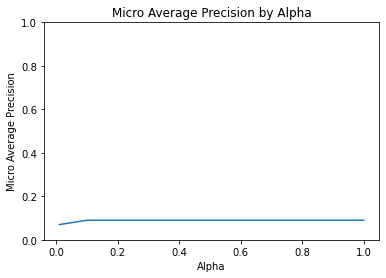

In [9]:
#make df
alpha_dict = {'alpha': [0.01, 0.1, 1], 'micro_avg_precision': [0.07, 0.09, 0.09]}
df_alpha = pd.DataFrame(data=alpha_dict)

#plot df
df_alpha.plot.line(x='alpha', y='micro_avg_precision', ylim=(0,1), ylabel='Micro Average Precision', xlabel='Alpha', title='Micro Average Precision by Alpha', legend=False)

<AxesSubplot:title={'center':'Micro Average Precision by Alpha'}, xlabel='Seed Confidence', ylabel='Micro Average Precision'>

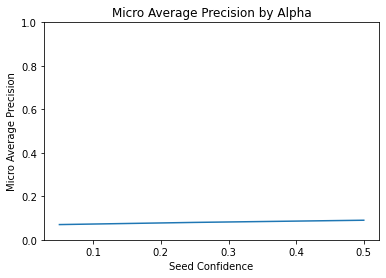

In [10]:
#make df
seed_confidence_dict = {'seed_confidence': [0.05, 0.25, 0.5], 'micro_avg_precision': [0.07, 0.08, 0.09]}
df_seed_confidence = pd.DataFrame(data=seed_confidence_dict)

#plot df
df_seed_confidence.plot.line(x='seed_confidence', y='micro_avg_precision', ylim=(0,1), ylabel='Micro Average Precision', xlabel='Seed Confidence', title='Micro Average Precision by Alpha', legend=False)